<a href="https://colab.research.google.com/github/delhian/NIR/blob/main/BERTScore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import numpy as np
import random
import umap.umap_ as umap
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
# from bokeh.models import ColumnDataSource, LabelSet, Legend, HoverTool, WheelZoomTool
from bokeh.models import ColumnDataSource, LabelSet, LegendItem, Legend, \
HoverTool, WheelZoomTool, PanTool, BoxZoomTool, ResetTool, TapTool, SaveTool
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook, push_notebook, show
output_notebook()
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)
import time
from tqdm.notebook import tqdm
from sklearn.metrics.pairwise import paired_cosine_distances, cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances
from random import choice
import warnings
warnings.filterwarnings('ignore')
from procrustes import generic, rotational, orthogonal, symmetric
from deep_translator import GoogleTranslator, PonsTranslator, YandexTranslator, LibreTranslator, LingueeTranslator
from scipy.stats import spearmanr, kendalltau

gt = GoogleTranslator(source='ru', target='en')

from sklearn.feature_extraction.text import TfidfVectorizer



Loading BokehJS ...

In [ ]:
# pairs = pd.read_pickle('./pairs.pkl')[['en']]
# pairs['en'] = pairs['en'].str.replace('\n',' ')
# pairs.to_csv('pairs_en.csv', index = False)

In [ ]:
# %%time

# # deep translator:
# pairs['deeptrans'] = pd.read_csv('pairs_enDT.csv', encoding='windows-1251', \
#             delimiter='\n',)['ru']

# # google translator:
# gt = GoogleTranslator(source='en', target='ru')
# pairs['google'] = pairs['en'].apply(lambda x: gt.translate(x))

# # yandex translator:
# pairs['yandextrans'] = pd.read_csv('pairs_enYT.csv', encoding='windows-1251', \
#             delimiter='\n',)['ru']

# # LIBRE translate:
# pairs['libretrans'] = pd.read_csv('pairs_enLT.csv', encoding='windows-1251', \
#             delimiter='\n',)['ru']

# pairs.to_excel('machine_translations.xlsx', index =False)
# pairs.to_pickle('machine_translations.pkl')

In [ ]:
# model_name ='bert-base-multilingual-cased'
# model_multi = AutoModel.from_pretrained(model_name)
# tokenizer_multi = AutoTokenizer.from_pretrained(model_name)

# - непригодно, так как токены чаще всего представляют из себя обрывки слов типа:
#     ['В', 'конце', 'М', '##ейн', 'С', '##три', '##т', 'ки', '##ш', '##мя', 'ки', '##шел', '##и', 'пат', 
# '##ру', '##льные', 'пол', '##ице', '##йские', 'а', '##вт', '##омобили', ',', 'пер', '##еми', '##ги', '##вая',
# '##сь', 'гол', '##уб', '##ыми', 'фон', '##аря', '##ми', 'на', 'к', '##ры', '##ша', '##х', ',', 'теле', 
# '##ви', '##зи', '##он', '##ные', 'ф', '##ург', '##оны', ',', 'там', 'и', 'сям', 'небо', '##льшие', 'к', 
# '##уч', '##ки', 'людей', '.']

model_name ='bert-base-cased'
model_en = AutoModel.from_pretrained(model_name)
tokenizer_en = AutoTokenizer.from_pretrained(model_name)

# model_name ='bert-base-multilingual-cased'
# model_multi = AutoModel.from_pretrained(model_name)
# tokenizer_multi = AutoTokenizer.from_pretrained(model_name)

# model_name ='DeepPavlov/rubert-base-cased-sentence/
model_name ='DeepPavlov/rubert-base-cased'
tokenizer_ru = AutoTokenizer.from_pretrained(model_name)
model_ru = AutoModel.from_pretrained(model_name)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationshi

In [ ]:

# pairs = pd.read_excel('resorch.xlsx')
# pairs = pairs.dropna()

# pairs['score_1'] = pairs['score_1'] + 1
# pairs['score_2'] = pairs['score_2'] + 1
# pairs['score_3'] = pairs['score_3'] + 1

# # Выравниваем score:

# min_score = pairs.loc[c1][['score_1', 'score_2']].min(axis = 1)

# pairs.loc[c1, 'score_1'] = min_score
# pairs.loc[c1, 'score_2'] = min_score

# c1 = pairs.version_2 == pairs.version_3

# min_score = pairs.loc[c1][['score_2', 'score_3']].min(axis = 1)

# pairs.loc[c1, 'score_2'] = min_score
# pairs.loc[c1, 'score_3'] = min_score

# c1 = pairs.version_1 == pairs.version_3

# min_score = pairs.loc[c1][['score_1', 'score_3']].min(axis = 1)

# pairs.loc[c1, 'score_1'] = min_score
# pairs.loc[c1, 'score_3'] = min_score


# # # filter:
# pairs = pairs[pairs[['score_'+str(x) for x in range (1,4)]].apply(lambda x:sorted(list(x)) == \
#                                                           list(range (1,4)), axis=1)].reset_index(drop=True)

# n_versions = 3

# scores = ['score_' + str(x) for x in range(1, n_versions+1)]

# pairs[scores] = pairs[scores].astype('int')
# print(pairs.shape)

In [ ]:
pairs = pd.read_excel('machine_translations_scored.xlsx')

print(pairs.shape)

# Выравниваем score:
c1 = pairs.version_1 == pairs.version_2

min_score = pairs.loc[c1][['score_1', 'score_2']].min(axis = 1)

pairs.loc[c1, 'score_1'] = min_score
pairs.loc[c1, 'score_2'] = min_score

c1 = pairs.version_2 == pairs.version_3

min_score = pairs.loc[c1][['score_2', 'score_3']].min(axis = 1)

pairs.loc[c1, 'score_2'] = min_score
pairs.loc[c1, 'score_3'] = min_score

c1 = pairs.version_1 == pairs.version_3

min_score = pairs.loc[c1][['score_1', 'score_3']].min(axis = 1)

pairs.loc[c1, 'score_1'] = min_score
pairs.loc[c1, 'score_3'] = min_score

# filter:
pairs = pairs[pairs[['score_'+str(x) for x in range (1,5)]].\
      apply(lambda x:sorted(list(x)) == list(range (1,5)), axis=1)].iloc[:, :-2].reset_index(drop=True)
n_versions = 4
scores = ['score_' + str(x) for x in range(1, n_versions+1)]

pairs[scores] = pairs[scores].astype('int')
print(pairs.shape)

(93, 11)
(70, 9)


In [ ]:
dic_ru_en ={}

In [ ]:
%%time


replacement_list = ['there', 'the', 'a', 'in', 'am', 'to', 'out', 'down', 'at', 'will','was', 'away', 'have', \
                    ' off', 'of', 'piece', 'is', 'it','by', 'if', 'got', 'looks', 'only', 'be']

# pairs = pd.read_pickle('./machine_translations.pkl')

emb_ru_list = []

def get_valid_words(x, reg):
    t = re.findall(reg, x)
    if len(t) == 0:
        return ''
    return t[0]

def f_dfmake(pairs, tokenizer, model, translate):
    emb = []
    for txt in pairs.values:
#         print(seq)
#         print(txt)
        seq_tokenized = tokenizer.tokenize(txt)
#         seq_tokenized_lower = [x.lower() for x in seq_tokenized]
        encoded_input = tokenizer(txt, return_tensors='pt')
        out = model(**encoded_input)[0][0,1:-1]
        out = out.detach().numpy()
# --normalize:
#         out /= np.sqrt(np.sum(out ** 2, axis=1)).reshape(-1,1)
        len_seq_tokenized = len(seq_tokenized)
        token = ''
        out_vec = []
        i = 1
        sent_dict = {}
        for token_ind in range(len_seq_tokenized -1 , -1, -1):
            tmp_token = seq_tokenized[token_ind]
            token = tmp_token + token
            out_vec.append(out[token_ind, :])
            if '#' in tmp_token:
                continue
            token = token.replace('#', '')
            token_lower = token.lower()
            
            if translate:
                token_en = dic_ru_en.get(token_lower, '')
                if token_en == '':
                    try:
                        token_en = gt.translate('!'+token_lower)[1:].lower().strip()
                        token_en_old = token_en
                        token_en_splitted = token_en.split(' ')
                        if len(token_en_splitted) > 1:
                            token_en = ' '.join([x for x in token_en_splitted if x not in replacement_list])
                            if token_en == '':
                                token_en = token_en_splitted[-1]
                        if token_en_old != token_en:
                            print(token_lower, ':', token_en_old, end = ' => ')
                            print(token_en, end = '\n')
                    except:
#                             print(token_lower)
#                         token_en = token_lower
                        token_en = ''
                    dic_ru_en[token_lower] = token_en
    #                     print(token_lower, en, len(dic_ru_en))
            else:
                token_en = token_lower

            out_vec = np.mean(out_vec, axis=0)
#             out_vec /= np.sqrt(np.sum(out_vec ** 2))

            token_number = sent_dict.get(token_lower, 0)
            sent_dict[token_lower] = token_number + 1
        
            emb.append([token_lower, token, txt , out_vec, sent_dict[token_lower], token_ind, token_en])
            token = ''
            out_vec = []
            
#         print(sent_dict)

    emb = pd.DataFrame(emb)
    
    emb.columns = ['token', 'token_row', 'txt', 'word_embedding', 'token_number', 'token_ind', 'token_en']
    
    emb['token_number'] = emb.groupby(['txt', 'token'], as_index = False)['token_number'].transform("max")\
    ['token_number'] - emb['token_number'] + 1
    
    emb = emb.sort_values(['txt', 'token_ind'])
    return emb

# emb_ru_deeptrans = f_dfmake (pairs['deeptrans'], tokenizer_ru, model_ru, True)
# emb_ru_google = f_dfmake (pairs['google'], tokenizer_ru, model_ru, True)
# emb_ru_yandextrans = f_dfmake (pairs['yandextrans'], tokenizer_ru, model_ru, True)
# emb_ru_libretrans = f_dfmake (pairs['libretrans'], tokenizer_ru, model_ru, True)

for i in range (1, n_versions + 1):
#     print(i)
    emb_ru_version = f_dfmake(pairs[f'version_{i}'], tokenizer_ru, model_ru, True)
    
#     filter valid words only:
#     emb_ru_version['token'] = emb_ru_version['token'].apply(lambda x: get_valid_words (x, '^[а-я0-9-]{1,}$'))
#     emb_ru_version = emb_ru_version[emb_ru_version.token != '']

    emb_ru_version.to_pickle(f'./emb_ru_version_{i}.pkl', )
    
    print(emb_ru_version.shape)
    
    emb_ru_list.append(emb_ru_version)

emb_en = f_dfmake (pairs['en'], tokenizer_en, model_en, False)

#     filter valid words only:
# emb_en['token'] = emb_en['token'].apply(lambda x: get_valid_words (x, '^[a-z0-9-#]{1,}$')) 
# emb_en = emb_en[emb_en.token != '']

print(emb_en.shape)

emb_en.to_pickle('./emb_en.pkl', )

на : on the => on
он : is he => he
который : which the => which
было : it was => was
машина : a car => car
фотография : the photo => photo
ей : to her => her
почтой : by mail => mail
будто : as if => as
вечером : in the evening => evening
немного : a little => little
выросли : have grown => grown
торчащей : sticking out => sticking
ему : to him => him
торчащее : sticking out => sticking
вещей : of things => things
сбил : shot down => shot
чуть : a little => little
черный : the black => black
стояла : was standing => standing
легла : lay down => lay
вырван : torn out => torn
конверт : the envelope => envelope
вам : to you => you
вышел : came out => came
прилег : lie down => lie
сел : sat down => sat
платье : the dress => dress
лучшее : the best => best
место : a place => place
утром : in the morning => morning
задавался : was asked => asked
выпадало : dropped out => dropped
(1701, 7)
вынул : took out => took
единственный : the only one => one
вместо : instead of => instead
выпячивал : s

In [ ]:
# emb_en = pd.read_pickle(f'./emb_en.pkl')
# emb_en.head()

# Absolute orientation 
# https://www.cs.utah.edu/docs/techreports/2017/pdf/UUCS-17-003.pdf
# https://arxiv.org/pdf/1806.01330.pdf

Анкерные пары слов ru - en:

In [ ]:
def f_get_pairs(emb_ru_list, emb_en, pairs):
    pairs_list = []
    for i, emb_ru in enumerate(emb_ru_list):
        emb_en_ = emb_en.copy()
        col_ru = f'version_{i+1}'
        pairs_ = pairs[['en', col_ru]]
        emb_ru = emb_ru.reset_index().set_index('txt')
        emb_en_ = emb_en_.reset_index().set_index('txt')
        emb_en_ = emb_en_.join(pairs_.set_index('en'))[['token_en','index', 'token_number']].reset_index()

        emb_en_.columns = ['en', 'token_en', 'index_en', 'token_number']
        emb_ru = emb_ru.join(pairs_.set_index(col_ru))[['token_en','token','index','en', 'token_number']]\
        .reset_index()
        emb_ru.columns = ['ru', 'token_en', 'token_ru', 'index_ru', 'en', 'token_number']

        pairs_ = pd.merge(emb_en_, emb_ru).sort_values('index_en')
        pairs_ = pairs_[['index_en', 'token_en' ,'en', 'index_ru','token_ru', 'ru']]
        pairs_list.append(pairs_)
    return pairs_list

In [ ]:
%%time

pairs_list = f_get_pairs(emb_ru_list, emb_en, pairs)

CPU times: user 73.3 ms, sys: 1.88 ms, total: 75.2 ms
Wall time: 73.8 ms


In [ ]:
class AbsoluteOrientation:
    def __init__(self, R=None, Y_mean=None):
        self.R = R
        self.Y_mean = Y_mean
    def fit(self, X, Y):
        self.R = orthogonal(X, Y,).t
        return self
    def predict(self, X):
        return np.dot(X, self.R).tolist()

In [ ]:
emb_ru_list_old = []
for i in range (n_versions):
    emb_ru_list_old.append(emb_ru_list[i])
    
# emb_ru_list = []
# for i in range (1, n_versions+ 1):
#     print(i)
#     emb_ru_list.append(pd.read_pickle(f'./emb_ru_version_{i}.pkl'))

In [ ]:
%%time

X = []
Y = []

for i in range(len(pairs_list)):
    pl = pairs_list[i]
    tmp = np.array(pl[['index_ru', 'index_en']])
    X.append(np.stack(emb_ru_list[i].loc[tmp[:,0]]['word_embedding']))
    Y.append(np.stack(emb_en.loc[tmp[:,1]]['word_embedding']))

ao = AbsoluteOrientation().fit(np.vstack(X), np.vstack(Y))

for i in range(len(pairs_list)):
    emb_ru_list[i]['word_embedding'] = ao.predict(np.stack(emb_ru_list[i]['word_embedding']))

CPU times: user 2.38 s, sys: 345 ms, total: 2.72 s
Wall time: 637 ms


In [ ]:
# %%time
# #  вариант 2: ортогональное преобразование для каждого предложения!
# for ind, row in pairs.iterrows():
#     print(row.en, ' : ')
#     X = []
#     Y = []
#     for i in range(len(pairs_list)):
#         tmp = np.array(pairs_list[i][pairs_list[i].en == row.en][['index_ru', 'index_en']])
#         X.append(np.stack(emb_ru_list[i].loc[tmp[:,0]]['word_embedding']))
#         Y.append(np.stack(emb_en.loc[tmp[:,1]]['word_embedding']))
#         print(X[-1].shape, Y[-1].shape)
#     print(np.vstack(X).shape, np.vstack(Y).shape)
    
#     ao = AbsoluteOrientation().fit(np.vstack(X), np.vstack(Y))
    
#     for i in range(len(pairs_list)):
#         print(row['version_'+str(i+1)])
#         cond = emb_ru_list[i].txt == row['version_'+str(i+1)]
#         print(emb_ru_list[i].loc[cond].shape)
#         PR = ao.predict(np.stack(emb_ru_list[i].loc[cond]['word_embedding']))
#         print(len(PR))
#         emb_ru_list[i].loc[cond]['word_embedding'] = PR

In [ ]:
# pairs_tmp = pairs[pairs.en == 'He brought out a small white box and set it on the counter.']

In [ ]:
# # tfe = TfidfVectorizer(token_pattern= "[a-z0-9]{1,}|[-\.\,!?:;\'\"()/—«»]")
# # tfe.fit(emb_en['txt'])

# # tfr = TfidfVectorizer(token_pattern= "[a-zа-яё0-9]{1,}|[-\.\,!?:;\'\"()/—«»]")
# # tfr.fit(pd.concat(emb_ru_list)['txt'])

# word_to_idf = [[x, tfe.idf_[tfe.vocabulary_[x]]] for x in pd.concat(pairs_list)['token_en'].unique()]
# max_idf = max([idf for x, idf in word_to_idf])
# min_idf = min([idf for x, idf in word_to_idf])

# threshold = 1
# stop_en = [x for x, idf in word_to_idf if (max_idf - idf)/(max_idf - min_idf) > threshold]
# print(f'stop_en: {stop_en}')

# word_to_idf = [[x, tfr.idf_[tfr.vocabulary_[x]]] for x in pd.concat(pairs_list)['token_ru'].unique()]
# max_idf = max([idf for x, idf in word_to_idf])
# min_idf = min([idf for x, idf in word_to_idf])
# threshold = 1
# stop_ru = [x for x, idf in word_to_idf if (max_idf - idf)/(max_idf - min_idf) > threshold]
# print(f'stop_ru: {stop_ru}')

In [ ]:
pairs[pairs.spearmanr == 1]['en'].values

array(['A rusty old car, a car which had once been white but was now a faded no-color-call it Dirt Road Gray-was coming up the hill toward The Mellow Tiger, spreading a thick blue fog of exhaust behind it.',
       'She slipped into the Mustang, and as she turned to put her purse on the console, her eye happened on something white sticking out from beneath the passenger seat.',
       'He began to walk toward Alan, the red pinpricks in his eyes deepening.',
       'He had learned that lesson yesterday when he had come home to find those terrible pink slips taped up all over the house.',
       'Slowly, very slowly, Keeton clenched his fist on the pink slip.',
       "Keeton's bushy eyebrows drew together below his high, pink forehead in a thundercloud.",
       'Gaunt handed Ace a brown envelope.',
       'Rose took off his round rimless spectacles, polished them, and then settled them back in place, hiding the two small red spots high up on his nose.',
       'She was wearing her brig

In [ ]:
en_sentence = 'A rusty old car, a car which had once been white but was now a faded no-color-call it Dirt Road Gray-was \
coming up the hill toward The Mellow Tiger, spreading a thick blue fog of exhaust behind it.'

pairs_tmp = pairs[pairs.en == en_sentence]

In [ ]:
%%time

def get_bertscors(pairs, pairs_list, verbose = False):
    
    
    versions = ['version_' + str(x) for x in range(1, n_versions+1)]

    for candidate in versions:
        if verbose:
            print('*'*100)
            print(candidate)
        ind = int(candidate.split('_')[1]) - 1
        emb_ru = emb_ru_list[ind]

        for ix, row in pairs[['en', candidate]].iterrows():
            if verbose:
                print(row[candidate], '<=>', row.en,'\n')      
                
            filter_tokens = pairs_list[ind][pairs_list[ind].en == row.en]
            filter_tokens_en = filter_tokens['token_en'].tolist()
            tmp_en = emb_en[(emb_en.txt == row.en)&emb_en.token.isin(filter_tokens_en)]
            tmp_ru = emb_ru[(emb_ru.txt == row[candidate])&emb_ru.token_en.isin(filter_tokens_en)]
#             tmp_en = emb_en[emb_en.txt == row.en]
#             tmp_ru = emb_ru[emb_ru.txt == row[candidate]]

            precision = []
            for _, row_ru in tmp_ru.iterrows():
                if verbose:
                    print(row_ru.token, end = '=>' )
                d = cosine_similarity(np.array(row_ru['word_embedding']).reshape(1, -1), \
                      np.stack(tmp_en['word_embedding'].values))[0,:]
#                 if verbose:
#                     print(d, end = ' => ')
                ix_mx = np.argmax(d)
                if verbose:
                    print(tmp_en.iloc[ix_mx].token_en,': ', d[ix_mx])

    #             idf = tfr.idf_[tfr.vocabulary_[row_ru.token]]
    #             print(f'row_ru.token:{row_ru.token}, idf:{idf}',  '\n')
                precision.append(d[ix_mx])

            precision = np.mean(precision)
            if verbose:
                print(f'\nprecision : {precision}\n')
            recall = []
            for _, row_en in tmp_en.iterrows():
                if verbose:
                    print(row_en.token, end = '=>' )
                d = cosine_similarity(np.array(row_en['word_embedding']).reshape(1, -1), \
                      np.stack(tmp_ru['word_embedding'].values))[0,:]
#                 if verbose:
#                     print(d, end = ' => ')
                ix_mx = np.argmax(d)
                if verbose:
                    print(tmp_ru.iloc[ix_mx].token,': ', d[ix_mx])

    #             idf = tfe.idf_[tfe.vocabulary_[row_en.token]]
    #             print(f'row_en.token:{row_en.token}, idf:{idf}',  '\n')

                recall.append(d[ix_mx])
            recall = np.mean(recall)
            if verbose:
                print(f'\nrecall : {recall}\n')

            pairs.loc[ix, candidate +'_p'] = precision
            pairs.loc[ix, candidate +'_r'] = recall
            pairs.loc[ix, candidate +'_f'] = 2* precision*recall/(precision+recall)
        
    return pairs[['en'] + versions + scores +[x+'_f' for x in versions] ]

pairs = get_bertscors(pairs_tmp, pairs_list, verbose = True)

****************************************************************************************************
version_1
Ржавая старая машина, которая когда-то была белой, но теперь стала блеклой и бесцветной - назовем ее Dirt Road Gray - поднималась по холму в сторону The Mellow Tiger, распространяя за собой густой синий туман выхлопных газов. <=> A rusty old car, a car which had once been white but was now a faded no-color-call it Dirt Road Gray-was coming up the hill toward The Mellow Tiger, spreading a thick blue fog of exhaust behind it. 

ржавая=>rusty :  0.5940311884122397
старая=>old :  0.7434126312098865
машина=>car :  0.7797300245448255
которая=>which :  0.8296196480546549
была=>was :  0.839414209486045
белой=>white :  0.8325215559774721
но=>but :  0.861594720458978
теперь=>now :  0.8300000982876939
блеклой=>faded :  0.6276149839157192
назовем=>call :  0.8091349227374383
dirt=>dirt :  0.5988532524396584
road=>road :  0.6047597610576814
gray=>gray :  0.5521058104999301
холму=>hill :  0.

In [ ]:
pairs = get_bertscors(pairs, pairs_list, verbose = False)

In [ ]:
pairs[['score_' + str(x) +'_p' for x in range(1, n_versions+1)]]=\
pairs[['version_' + str(x) +'_f' for x in range(1, n_versions+1)]].\
apply(lambda x : 1+np.argsort(x).argsort(), axis = 1)

In [ ]:
scores = ['score_' + str(x) for x in range(1, n_versions+1)]
scores_p = ['score_' + str(x) +'_p' for x in range(1, n_versions+1)]

def get_spearmanr(t):
    r1 = t[scores].values.tolist()
    r2 = t[scores_p].values.tolist()
    r2 = [round(t, 8) for t in r2]
    return round(spearmanr(r1, r2)[0], 2)

def get_kendalltau(t):
    r1 = t[scores].values.tolist()
    r2 = t[scores_p].values.tolist()
    r2 = [round(t, 8) for t in r2]
    return round(kendalltau(r1, r2)[0], 2)

pairs['spearmanr'] = pairs.apply(get_spearmanr, axis = 1)
pairs['kendalltau'] = pairs.apply(get_kendalltau, axis = 1)
print(pairs['spearmanr'].mean())
print(pairs['kendalltau'].mean())

0.5714285714285713
0.4760000000000001


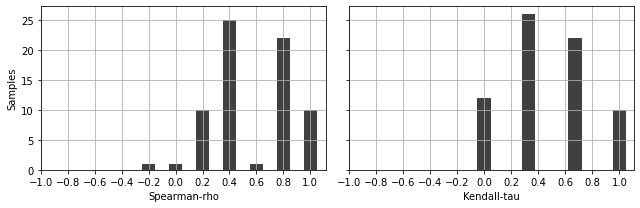

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (9, 3), sharey=True)
# fig.suptitle('Rank correlation coeff: ')

labels, counts = np.unique(pairs['spearmanr'], return_counts=True)

ax1.bar(labels, counts, align='center', width = 0.1, facecolor='black', alpha=0.75,)
ax1.set_xticks(np.linspace(-1,1,11))
ax1.grid()
ax1.set_xlabel('Spearman-rho')
ax1.set_ylabel('Samples')

labels, counts = np.unique(pairs['kendalltau'], return_counts=True)
ax2.bar(labels, counts, align='center', width = 0.1, facecolor='black', alpha=0.75,)
ax2.grid()
ax2.set_xlabel('Kendall-tau')
ax2.set_xticks(np.linspace(-1,1,11))
fig.tight_layout()
plt.show()


In [ ]:
    tmp = np.array(pl[['index_ru', 'index_en']])
    X.append(np.stack(emb_ru_list[i].loc[tmp[:,0]]['word_embedding']))
    Y.append(np.stack(emb_en.loc[tmp[:,1]]['word_embedding']))

In [ ]:
pairs[pairs.en == en_sentence]

Empty DataFrame
Columns: [en, version_1, version_2, version_3, version_4, score_1, score_2, score_3, score_4, version_1_f, version_2_f, version_3_f, version_4_f, score_1_p, score_2_p, score_3_p, score_4_p, spearmanr, kendalltau]
Index: []

In [ ]:
def f_plot(pairs, emb_ru_list, emb_en, en_sentence, n_neighbors , min_dist):
    engines = ['DeepL','GoogleTranslate', 'YandexTranslate', 'LibreTranslate']
    n_versions = len(engines)
    pairs_list_short = []
    
    for i in range(n_versions):
        pairs_list_short.append(pairs_list[i][pairs_list[i].en == en_sentence][['index_en', 'index_ru']])

    ru_sentences = pairs[pairs.en == en_sentence]\
    [[f'version_{x}' for x in range(1, n_versions + 1)]].values.tolist()[0]
    
    ru_f1s = np.round(pairs[pairs.en == en_sentence]\
    [[f'version_{x}_f' for x in range(1, n_versions + 1)]].values.tolist()[0], 4)

    ru_embeddings = [emb_ru_list[i][emb_ru_list[i]['txt'] == ru_sentences[i]] for i in range(n_versions)]
    
    vec_ru = np.vstack(em['word_embedding'].values.tolist() for em in ru_embeddings)
    
#     ru_embeddings['txt_plus'] = ru_embeddings['txt'] + 

    en_embeddings = emb_en[emb_en.txt == en_sentence]
    vec_en = np.stack(en_embeddings['word_embedding'].values.tolist())

    u_map = umap.UMAP( metric='cosine', n_neighbors = n_neighbors, min_dist = min_dist)
    u_map.fit(np.vstack([vec_ru, vec_en]))

    arr_proj_en = u_map.transform(vec_en)
    en_embeddings['x'], en_embeddings['y'] = arr_proj_en[:,0], arr_proj_en[:,1]
    
    engines = ['DeepL','GoogleT', 'YandexT', 'LibreT']
    
    for i in range(n_versions):
        arr_proj_ru = u_map.transform(ru_embeddings[i]['word_embedding'].values.tolist())
        ru_embeddings[i]['x'], ru_embeddings[i]['y'] = arr_proj_ru[:,0], arr_proj_ru[:,1]
        ru_embeddings[i]['txt_plus'] = ru_embeddings[i]['txt'].map(lambda x: f'{engines[i]}:  {x} (F1 = {ru_f1s[i]})')
        
#     hover = HoverTool(tooltips=[("index", "$index"), ('txt', '@txt')], names=['en', 'ru'])
    
#     tools = [hover_1, hover_2, WheelZoomTool(), PanTool(), BoxZoomTool(), ResetTool(), SaveTool()]

    tools = [WheelZoomTool(), PanTool(), BoxZoomTool(), ResetTool(), SaveTool()]
    
    p = figure(title = "Contextualized word embedding: UMAP-projection",\
               plot_width=900, plot_height = 700, tools = tools)
    p.title.align = 'center'
    

    p.scatter(x='x', y='y', size=12,
            source = ColumnDataSource(en_embeddings),
            legend_group='txt',\
            fill_alpha=1,
            color='grey',
            line_color='black',
            marker='circle',
            hit_dilation = 1,
#             name='en'
            )
    
    labels_en = LabelSet(x='x',
                      y='y',
                      text='token_row',
#                       x_offset=7,
#                       y_offset=7,
                      source=ColumnDataSource(en_embeddings),
                      text_color = "black",
#                       background_fill_color = 'white',
                      text_font_size="6pt")

    p.add_layout(labels_en)
    

    markers = ['diamond','triangle', 'square', 'star']
    colors = ['white'] * 4

    for i in range(n_versions):
        p.scatter(x='x', y='y', size=12,
                source = ColumnDataSource(ru_embeddings[i]),
                legend_group='txt_plus',\
                fill_alpha=1,
                color=colors[i],
                line_color="black",
                marker= markers[i],
                hit_dilation = 1,
#                 name='ru'
                )
        labels_ru = LabelSet(x='x',
                          y='y',
                          text='token_row',
                          x_offset=7,
                          y_offset=7,
                          source=ColumnDataSource(ru_embeddings[i]),
                          text_color = "black",
    #                       background_fill_color = 'white',
                          text_font_size="6pt")
        
        p.add_layout(labels_ru)

 
    for i in range(n_versions):
        en_ = en_embeddings.loc[pairs_list_short[i]['index_en'].values]
        ru_ = ru_embeddings[i].loc[pairs_list_short[i]['index_ru'].values]
        
        en_points = en_[['x', 'y']].values
        ru_points = ru_[['x', 'y']].values
        
        for i in range(en_points.shape[0]):
            p.line([en_points[i][0], ru_points[i][0]], \
                   [en_points[i][1], ru_points[i][1]], line_dash = 'dotted', line_color = 'grey')
    
    p.legend.label_text_font_size = '7.5pt'
    legend = p.legend[0]
    p.add_layout(legend, 'above')
    show(p)
    
    
en_sentence = 'Rose took off his round rimless spectacles, polished them, and then \
settled them back in place, hiding the two small red spots high up on his nose.'

n_neighbors = 15
min_dist = 0.025

f_plot(pairs, emb_ru_list, emb_en, en_sentence, n_neighbors, min_dist)

In [ ]:
emb_en[emb_en.txt == en_sentence]